# Data Evaluation for Multi-Grasp motion planner

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Profiling
This section contains code to load, average and visualize profiling results.

In [2]:
    def load_stats(filename):
        """Load profiling stats for an algorithm from the given file.
        Args:
            filename, string: name of the stats file.
        Returns:
            pd.DataFrame: Profiling stats with standard deviations
        """
        run_stats = pd.read_csv(filename)
        avg_run_stats = run_stats.groupby('function_name').mean()
        time_columns = ['total_runtime', 'avg_runtime', 'total_cpu_time', 'avg_cpu_time']
        time_columns_std = [name + "_std" for name in time_columns]
        avg_run_stats[time_columns_std] = run_stats.groupby('function_name').std()[time_columns]
        return avg_run_stats

Show the profiling stats of a specific algorithm:

In [4]:
load_stats('/home/joshua/projects/placement_catkin/experiment_results/paper/2d/LazySP_LWLPAstar__LazyEdgeWeightedMultiGraspGraph__cluttered_field_dist__8-grasps__0.1-step_size__10000-batch_size__FirstUnknown-eetype/run_stats')


FileNotFoundError: [Errno 2] No such file or directory: '/home/joshua/projects/placement_catkin/experiment_results/paper/2d/LazySP_LWLPAstar__LazyEdgeWeightedMultiGraspGraph__cluttered_field_dist__8-grasps__0.1-step_size__10000-batch_size__FirstUnknown-eetype/run_stats'

## Loading summarized results
This section contains code to load summarized results, i.e. number of evaluated nodes, runtime, number of evaluated edges, ...

In [2]:
algo_to_function = {
    "LazySP_LWLPAstar_LazyGrown": 'lazySPLazyLayered',
    "LazySP_LLPAstar_LazyGrown": 'lazySPLazyLayered',
    "LazySP_LWLPAstar": 'lazySP',
    "LazySP_LLPAstar": 'lazySP',
    "LazySP_LPAstar": 'lazySP',
    "LWAstar": "lwaStarSearch",
    "LWLPAstar": "lpaStarSearch",
    "LPAstar": "lpaStarSearch",
    "Astar": "aStarSearch",
    # TODO add other algorithm to function mappings here
}

def get_function_name(algo, graph):
    if 'LazyGrown' in graph:
        return algo_to_function[algo + '_LazyGrown']
    else:
        return algo_to_function[algo]


def count_event(log_line, storage):
    """ Count a roadmap evalation log event.
    Args:
        log_line, str - a line from a log file.
        storage, dict - dictionary to update counts in.
            Needs to have keys 'base_validity', 'grasp_validity', 'base_cost', 'grasp_cost', 'base_expansions'. 'grasp_expansions'
    """
    line_args = log_line.split(',')
    storage['base_validity'] += line_args[0] == "VAL_BASE"
    storage['grasp_validity'] += line_args[0] == "VAL_GRASP"
    storage['base_cost'] += line_args[0] == "EDGE_COST"
    storage['grasp_cost'] += line_args[0] == "EDGE_COST_GRASP"
    storage['base_expansions'] += line_args[0] == "BASE_EXPANSION"
    storage['grasp_expansions'] += line_args[0] == "EXPANSION"

def toTestCaseId(scene_name, num_grasps, step_size, batch_size, ee_type, lmbda):
    return scene_name + '__' + str(num_grasps) + '__' + str(step_size) + '__' + str(batch_size) + '__' + str(ee_type) + '__' + str(lmbda)

def retrieve_value(df, row, col, default_val):
    try:
        return df.loc[row, col]
    except KeyError:
        return default_val

def parse_folder_name(folder_name):
    value_key_pairs = folder_name.split('__')
    info = {'algo_name': value_key_pairs[0], 'graph_name': value_key_pairs[1], 'scene_name': value_key_pairs[2], 'lambda': 'default'}
    for value_key_str in value_key_pairs[3:]:
        val, key = value_key_str.split('-')
        info[key] = val
    return info

def load_test_case_result(result_folder, runtime_type='total_runtime'):
    """Load the result of a single test case and return it as a pandas.Series.
    Args:
        result_folder, string: The folder containing the results of the test case.
            The folder should contain four files 'log_evaluation', 'log_roadmap', 'run_stats' and 'results' produced
            by testing the MGSearchMotionPlanner. The name of the result folder should follow the format
            <algo_name>__<graph_name>__<scene_name>__<num_grasps>
    """
    folder_name = os.path.basename(os.path.normpath(result_folder))
    test_case_info = parse_folder_name(folder_name)
    num_grasps = int(test_case_info['grasps'])
    step_size = float(test_case_info['step_size'])
    batch_size = int(test_case_info['batch_size'])
    algo_name = test_case_info['algo_name']
    graph_name = test_case_info['graph_name']
    lmbda = test_case_info['lambda']
    try:
        # cast to float if possible
        lmbda = float(lmbda)
    except ValueError:
        pass

    # load runtime statistics
    avg_run_stats = load_stats(result_folder + '/run_stats')
    # read number of roadmap nodes
    # with open(result_folder + '/log_roadmap', 'r') as roadmap_file:
    #     num_nodes = len(roadmap_file.readlines())
    # read number of validity checks, edge evaluations and expansions
    # roadmap_evaluations = {'base_validity': 0, 'grasp_validity': 0, 'base_cost': 0, 'grasp_cost': 0, 'base_expansions': 0, 'grasp_expansions': 0}
    # with open(result_folder + '/log_evaluation', 'r') as evalulation_file:
    #     for line in evalulation_file:
    #         count_event(line, roadmap_evaluations)
    # read planning results
    planning_results = pd.read_csv(result_folder + '/results')
    # perform sanity checks
    uniqueness = planning_results.nunique()
    if uniqueness[uniqueness != 1].size > 0:
        raise ValueError("ERROR: The results in folder %s are inconsistent:\n %s" % (result_folder, str(planning_results)))
    # Create Series for this test case
    return pd.Series({'algorithm': algo_name, 
                      'graph': graph_name, 
                      'edge_selector_type': test_case_info['eetype'],
                      'runtime': avg_run_stats.loc[get_function_name(algo_name, graph_name), runtime_type],
                      'runtime_std': avg_run_stats.loc[get_function_name(algo_name, graph_name), runtime_type + '_std'],
                      'base_validity_checks': int(retrieve_value(avg_run_stats, 'StateSpace::isValid', 'num_calls', 0)),
                      'grasp_validity_checks': int(retrieve_value(avg_run_stats, 'StateSpace::isValidWithGrasp', 'num_calls', 0)),
                      'base_edge_cost': int(retrieve_value(avg_run_stats, 'IntegralEdgeCostComputer::cost', 'num_calls', 0)),
                      'grasp_edge_cost': int(retrieve_value(avg_run_stats, 'IntegralEdgeCostComputer::cost::grasp', 'num_calls', 0)),
                      'batch_size': batch_size,
                      'scene': test_case_info['scene_name'], 
                      'num_grasps': num_grasps,
                      'step_size': step_size,
                      'cost': planning_results['cost'].iloc[0],
                      'goal_id': planning_results['goal_id'].iloc[0],
                      'lambda': lmbda,
                      'test_case_id': toTestCaseId(test_case_info['scene_name'], num_grasps, step_size, batch_size, test_case_info['eetype'], lmbda)})

def load_results(results_base_folder, runtime_type):
    """Load all results in the given base folder and return in a single DataFrame.
    Args:
        results_base_folder, str: Path to the folder containing various result sub-folders.
    Returns:
        pd.DataFrame: Data frame containing all results.
    """
    series = []
    for fname in os.listdir(results_base_folder):
        series.append(load_test_case_result(results_base_folder + '/' + fname, runtime_type))
    return pd.DataFrame(series)

In [10]:
def append_contents(to_file, from_file):
    with open(from_file, 'r') as from_content:
        lines = from_content.readlines()
    with open(to_file, 'a') as to_content:
        to_content.writelines(lines[1:])

base_path = '/home/joshua/projects/placement_catkin/experiment_results/paper/yumi_placing'

for tc in os.listdir(base_path):
    if 'LWAstar' in tc and 'LastUnknown' in tc:
        other_tc = base_path + '/' + tc[:tc.find('LastUnknown')] + '10.0-lambda__default-eetype/'
        append_contents(other_tc + 'run_stats', base_path + '/' + tc + '/run_stats')
        append_contents(other_tc + 'results', base_path + '/' + tc + '/results')
# from_path = '/home/joshua/projects/placement_catkin/experiment_results/paper/2d_updated_additional'
# to_path = '/home/joshua/projects/placement_catkin/experiment_results/paper/2d_updated_backup'

# for tc in os.listdir(from_path):
#     if os.path.exists(to_path + '/' + tc):
#         append_contents(to_path + '/' + tc + '/run_stats', from_path + '/' + tc + '/run_stats')
#         append_contents(to_path + '/' + tc + '/results', from_path + '/' + tc + '/results')
        

In [28]:
# [fname for fname in os.listdir('/home/joshua/projects/placement_catkin/experiment_results/paper/2d/') if len(fname.split('__')) == 7]
data = load_results('/home/joshua/projects/placement_catkin/experiment_results/paper/2d/', 'total_cpu_time')
data
# bla.loc[key]
# data.sort_values(['scene', 'algorithm'])
# pr = pd.read_csv('/tmp/test/LazySP_LWLPAstar__LazyWeightedMultiGraspGraph__Bugtrap2DScene__4/results')
# pr['cost'].iloc[0]

,algorithm,graph,edge_selector_type,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,batch_size,scene,num_grasps,step_size,cost,goal_id,lambda,test_case_id
0,LazySP_LWLPAstar,LazyGrownLazyEdgeWeightedMultiGraspGraph,LastUnknown,1.887663,0.077638,6726,90,12660,0,10000,cluttered_field_infeasible_dist,30,2.5,inf,0,default,cluttered_field_infeasible_dist__30__2.5__1000...
1,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,LastUnknown,5.051610,0.062845,2468,339,3829,432,5000,cluttered_field_dist,8,0.5,2084.62,13,default,cluttered_field_dist__8__0.5__5000__LastUnknow...
2,LazySP_LLPAstar,LazyGrownLazyWeightedMultiGraspGraph,LastUnknown,324.545000,NaN,5499,5723,50,12938,10000,cluttered_field_dist,16,0.5,2047.78,34,default,cluttered_field_dist__16__0.5__10000__LastUnkn...
3,LWAstar,SingleGraspGraph,default,0.757457,0.031629,510,1823,0,3188,10000,cluttered_field_dist_adv,8,0.1,inf,0,10.0,cluttered_field_dist_adv__8__0.1__10000__defau...
4,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,FirstUnknown,4.325983,0.320678,6484,46329,4690,0,10000,cluttered_field_infeasible_const,16,0.5,inf,0,10.0,cluttered_field_infeasible_const__16__0.5__100...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,LWAstar,SingleGraspGraph,default,8.195470,0.107714,6058,73196,0,66582,10000,cluttered_field_infeasible_const,30,0.5,inf,0,10.0,cluttered_field_infeasible_const__30__0.5__100...
3236,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,LastUnknown,2.057530,0.042055,3809,149,2863,109,10000,cluttered_field_const,8,0.5,1994.45,4,default,cluttered_field_const__8__0.5__10000__LastUnkn...
3237,LWAstar,MultiGraspGraph,FirstUnknown,0.022649,0.000438,114,420,0,355,1000,cluttered_field_dist_adv,16,2.5,inf,0,10.0,cluttered_field_dist_adv__16__2.5__1000__First...
3238,LazySP_LLPAstar,LazyGrownMultiGraspGraph,LastUnknown,6.096470,NaN,4196,29726,0,267,10000,cluttered_field_const,30,2.5,1977.86,86,default,cluttered_field_const__30__2.5__10000__LastUnk...


In [6]:

# data2 = load_results('/home/joshua/projects/placement_catkin/experiment_results/paper/2d_updated_additional')
yumi_data = load_results('/home/joshua/projects/placement_catkin/experiment_results/paper/yumi')
# len(yumi_data)

In [3]:
data = pd.read_csv('/home/joshua/projects/placement_catkin/experiment_results/paper/2d.csv')
# data
# data.to_csv('/home/joshua/projects/placement_catkin/experiment_results/paper/2d.csv', index=False)

In [14]:
# data_annotated = data.assign(test_case=data['scene'] + '__' + data['num_grasps'].astype(str) + '__' + data['step_size'].astype(str) + '__' + data['roadmap_size'].astype(str))
# grouped = data_annotated.groupby('test_case')
# list(grouped.groups.keys())
# data['test_case_id'] = data['test_case_id'].str.replace('-batch_size', '')
# data[data['algorithm'] == 'LWAstar'].sort_values(['test_case_id'])
# data['scene'].unique()
# data[(data['algorithm'] == 'LazySP_LLPAstar') & (data['scene'] == 'cluttered_field_const') & (data['graph'] == 'MultiGraspGraph')]
np.minimum(data['runtime'], data['runtime'].max())

0        54.079400
1         7.868970
2         9.581957
3         5.787243
4        12.230700
           ...    
1777    860.433000
1778      0.183039
1779    130.667000
1780     50.327700
1781      1.739920
Name: runtime, Length: 1782, dtype: float64

In [16]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'max_colwidth', 200):
    # display(data['test_case_id'])
lu_data = data[data['edge_selector_type'] == 'LastUnknown']
fu_data = data[data['edge_selector_type'] == 'FirstUnknown']
grouped = lu_data.groupby('test_case_id')
# goal_stds = grouped['goal_id'].aggregate('std')
# goal_stds[goal_stds > 0.0]
# len(grouped.groups)
len(lu_data[lu_data['algorithm'] != 'LWAstar'])
# data['edge_selector_type'].unique()
# cost_stds[(~pd.isnull(cost_stds)) & (cost_stds != 0.0)]
# grouped.groups
# pd.set_option('display.max_rows', 50)
data[(data['scene'] == 'cluttered_field_const_adv') & (data['batch_size'] == 1000)].pivot(index=['step_size', 'num_grasps'],columns=['algorithm', 'graph', 'edge_selector_type'], values='runtime').sort_index(axis=1)['LazySP_LWLPAstar']


graph                LazyEdgeWeightedMultiGraspGraph              \
edge_selector_type                      FirstUnknown LastUnknown   
step_size num_grasps                                               
0.1       8                                 0.021784    0.026482   
          16                                0.029134    0.028792   
          30                                0.042990    0.041794   
0.5       8                                 0.012843    0.012433   
          16                                0.020516    0.019814   
          30                                0.032938    0.033353   
2.5       8                                 0.010397    0.009943   
          16                                0.019166    0.017789   
          30                                0.030930    0.030173   

graph                LazyGrownLazyEdgeWeightedMultiGraspGraph              \
edge_selector_type                               FirstUnknown LastUnknown   
step_size num_grasps                                                        
0.1       8                                          0.186197    0.150383   
          16                                         0.255109    0.191415   
          30                                         0.430787    0.267603   
0.5       8                                          0.100816    0.067957   
          16                                         0.164602    0.089971   
          30                                         0.338724    0.165357   
2.5       8                                          0.080472    0.049821   
          16                                         0.142057    0.070395   
          30                                         0.309414    0.140405   

graph                LazyGrownLazyWeightedMultiGraspGraph              \
edge_selector_type                           FirstUnknown LastUnknown   
step_size num_grasps                                                    
0.1       8                                      4.483553    1.896877   
          16                                    10.176567    4.111680   
          30                                    15.143400    8.631160   
0.5       8                                      3.945750    1.447697   
          16                                     9.709337    3.399570   
          30                                    14.136933    7.278200   
2.5       8                                      3.857917    1.331923   
          16                                     9.461127    3.192263   
          30                                    13.401000    6.947550   

graph                LazyGrownMultiGraspGraph              \
edge_selector_type               FirstUnknown LastUnknown   
step_size num_grasps                                        
0.1       8                          0.234415    0.203788   
          16                         0.359637    0.280014   
          30                         0.619286    0.483240   
0.5       8                          0.111446    0.078337   
          16                         0.188234    0.110180   
          30                         0.365193    0.213146   
2.5       8                          0.084456    0.053318   
          16                         0.146267    0.075825   
          30                         0.300012    0.151512   

graph                LazyWeightedMultiGraspGraph              
edge_selector_type                  FirstUnknown LastUnknown  
step_size num_grasps                                          
0.1       8                             1.995933    1.846887  
          16                            4.109953    3.978603  
          30                            8.772723    8.445457  
0.5       8                             1.440040    1.393637  
          16                            3.308587    3.324750  
          30                            7.334270    7.128997  
2.5       8                             1.284823    1.252027  
          16      

In [25]:
data[(data['scene'] == 'cluttered_field_const') & (data['batch_size'] == 5000) & (data['algorithm'] == 'LazySP_LLPAstar') & ((data['graph'] == 'MultiGraspGraph') | (data['graph'] == 'LazyGrownLazyEdgeWeightedMultiGraspGraph'))  & (data['step_size'] == 0.1) & (data['edge_selector_type'] == 'LastUnknown')].sort_values(['num_grasps', 'graph'])

,algorithm,graph,edge_selector_type,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,batch_size,scene,num_grasps,step_size,cost,goal_id,lambda,test_case_id
3056,LazySP_LLPAstar,LazyGrownLazyEdgeWeightedMultiGraspGraph,LastUnknown,3.66352,NaN,2162,4262,36,245,5000,cluttered_field_const,8,0.1,2009.98,4,default,cluttered_field_const__8__0.1__5000__LastUnkno...
691,LazySP_LLPAstar,MultiGraspGraph,LastUnknown,5.42721,NaN,2039,6934,0,189,5000,cluttered_field_const,8,0.1,2009.98,4,default,cluttered_field_const__8__0.1__5000__LastUnkno...
1231,LazySP_LLPAstar,LazyGrownLazyEdgeWeightedMultiGraspGraph,LastUnknown,3.18928,NaN,2150,6445,34,140,5000,cluttered_field_const,16,0.1,1990.08,34,default,cluttered_field_const__16__0.1__5000__LastUnkn...
444,LazySP_LLPAstar,MultiGraspGraph,LastUnknown,3.99417,NaN,2037,11962,0,133,5000,cluttered_field_const,16,0.1,1990.08,34,default,cluttered_field_const__16__0.1__5000__LastUnkn...
824,LazySP_LLPAstar,LazyGrownLazyEdgeWeightedMultiGraspGraph,LastUnknown,8.47588,NaN,2286,13465,34,433,5000,cluttered_field_const,30,0.1,1990.08,34,default,cluttered_field_const__30__0.1__5000__LastUnkn...
2614,LazySP_LLPAstar,MultiGraspGraph,LastUnknown,12.16570,NaN,2176,22787,0,397,5000,cluttered_field_const,30,0.1,1990.08,34,default,cluttered_field_const__30__0.1__5000__LastUnkn...


In [15]:
def verify_results(data):
    """ Check that in the given data all algorithms agree on the same cost for each test cases
        and that all test cases are complete. 
    """
    grouped = data.groupby('test_case_id')
    if (grouped['cost'].aggregate('std') > 0.0).any():
        return False
    if (grouped['goal_id'].aggregate('std') > 0.0).any():
        return False
    # return len(data) / len(grouped.groups) == list(grouped.groups.values())[0].shape[0]
    return True

verify_results(data)
data['scene']
# verify_results(yumi_data)

0        cluttered_field_infeasible_dist
1                   cluttered_field_dist
2                   cluttered_field_dist
3               cluttered_field_dist_adv
4       cluttered_field_infeasible_const
                      ...               
3235    cluttered_field_infeasible_const
3236               cluttered_field_const
3237            cluttered_field_dist_adv
3238               cluttered_field_const
3239    cluttered_field_infeasible_const
Name: scene, Length: 3240, dtype: object

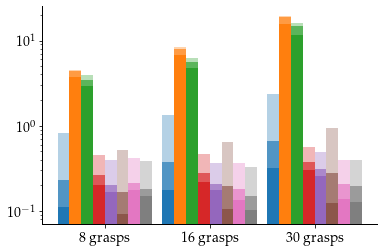

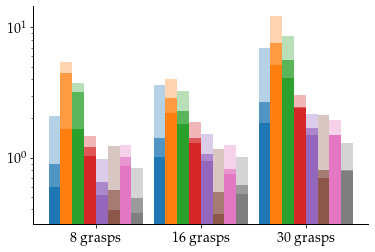

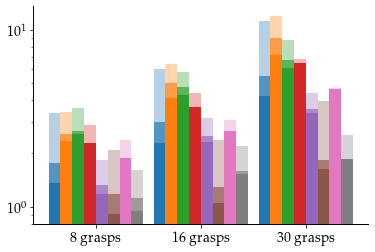

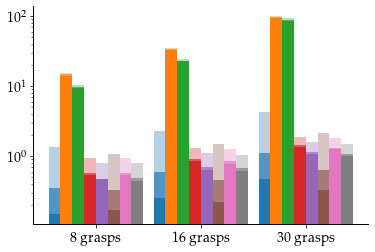

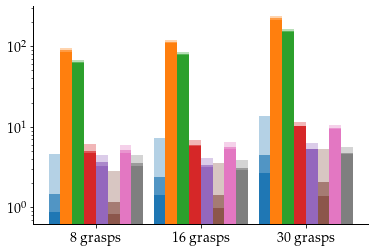

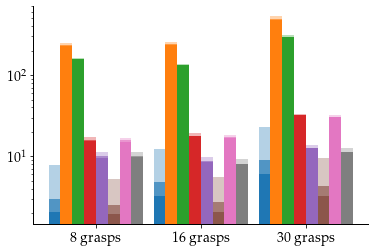

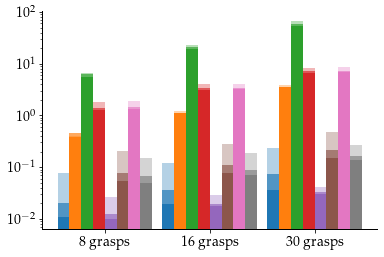

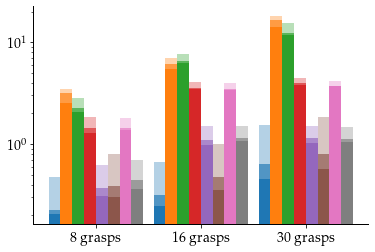

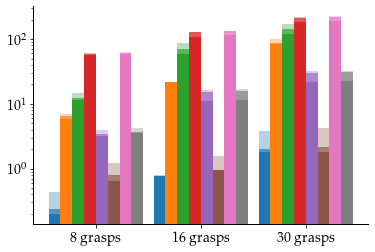

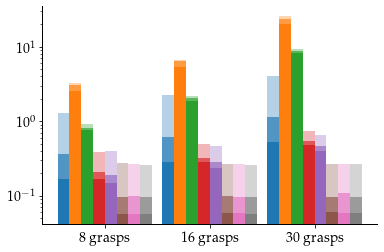

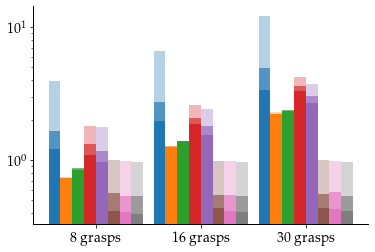

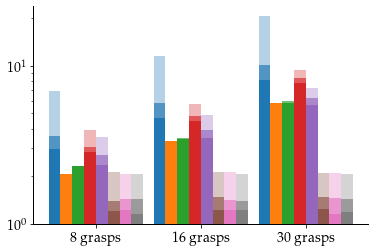

In [13]:
from matplotlib import cm
import bisect

pretty_algo_names = {
    'LWAstar': 'LWA*',
    'LWLPAstar': 'LWLPA*',
    'LazySP_LWLPAstar': 'LazySP + LWLPA*',
    'LazySP_LLPAstar': 'LazySP + LPA*',
}

pretty_graph_names = {
    'SingleGraspGraph': 'SG',
    'MultiGraspGraph': 'MG',
    'LazyGrownLazyEdgeWeightedMultiGraspGraph': 'LGW, LG-MG',
    'LazyGrownLazyWeightedMultiGraspGraph': 'ELGW, LG-MG',
    'LazyGrownMultiGraspGraph': 'LW, LG-MG',
    'LazyEdgeWeightedMultiGraspGraph': 'LGW, MG',
    'LazyWeightedMultiGraspGraph': 'ELGW, MG'
}

def configure_latex():
    """
        Configure matplotlib to use latex in a pretty way
    """
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Palatino',
        'font.size': 14,
        'legend.fontsize': 12,
        'legend.labelspacing': 0,
        'legend.markerscale': 0.1,
        'text.usetex': True,
        'savefig.dpi': 300})


def simplify_axis(axis):
    """
        Simplify axis
    """
    axis.set_frame_on(False)
    xmin, xmax = axis.get_xaxis().get_view_interval()
    ymin, ymax = axis.get_yaxis().get_view_interval()
    axis.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.get_yaxis().tick_left()
    axis.get_xaxis().tick_bottom()

def prettify(algo_graph):
    # return str(algo_graph)
    # return algo_graph
    return pretty_algo_names[algo_graph[0]] + ', ' + pretty_graph_names[algo_graph[1]]

# test_case = 'cluttered_field_dist_adv__8__0.1__1000'

def annotate_caps(axis, rects, max_height):
    """ Render some marking at the top of those rectangles that have the given max height.
        Args:
            axis(?): Axis from matplotlib
            rects(?): rectangles returned from axis.bar(...)
            max_height(float): the maximal height
    """
    for rect in rects:
        if rect.get_height() == max_height:
            axis.annotate('', xy=(rect.get_x() + rect.get_width() / 2, max_height), arrowprops={'arrowstyle': '<-'}, xytext=(0, 20), textcoords="offset pixels", ha='center', va='bottom')

def plot_runtimes(data, scene, batch_size, algo_graph_combos, ee_type='LastUnknown', variants=None, reverse_variants=False, max_runtime=None, bar_gap=0.1, save_path=None, min_relative_height=None, lower_plot_ratio=0.5, show_legend=True, variant_index='step_size', show_max_val=False, log_scale=False):
    """ Plot runtimes of different algorithm-graph combinations on the given scene for the given roadmap size.
        Args:
            data(pd.DataFrame) - the result data
            batch_size(int) - the batch size of the roadmap (different < roadmap_size)
            algo_graph_combos(list of tuple of string) - combinations of algorithm and graph to plot
            ee_types(optional, str) - plot for the given edge selector
            variants(optional, list) - the variants to plot runtimes for. If None, all variants are plotted. The type of variant can be specified through variant_index (step_size or lambda)
            variant_index(optional, str) - the name of the column that identifies different variants of the same test case (either step_size or lambda)
            reverse_variants(optional, bool) - If true, reverse order of variants, i.e. sort in descending order instead of ascending
            max_runtime(optional, float) - If provided max-out(cap) the bar plots at the given runtime
            bar_gap(optional, float) - the percentage (0, 1) of space that the gap between groups should take
            save_path(optional, str) - optionally a filepath to save the plot in
            min_relative_height(optional, float) - If provided, split the graph so that the minimal bar has the given relative height in the plot (value must be in [0, 1])
            show_legend(optional, bool) - show legend or not
            show_max_val(optional, bool) - if True show maximal value on legend
            log_scale(optional, bool) -  if True, plot log-10 scale
    """
    configure_latex()
    scene_data = data[(data['scene'] == scene) & (data['batch_size']  == batch_size) & ((data['edge_selector_type'] == ee_type) | (data['edge_selector_type'] == 'default'))]
    if len(scene_data) == 0:
        raise ValueError("Input data does not contain data for scene %s and batch size %d" % (scene, batch_size))
    # if log_scale:
        # scene_data['runtime'] = np.log10(scene_data['runtime'])
    plot_data = scene_data.pivot(index=[variant_index, 'num_grasps'],columns=['algorithm', 'graph'], values='runtime')
    # display(plot_data)
    if max_runtime is None:
        max_runtime = data['runtime'].max()
    if variants is None:
        variants = list(scene_data[variant_index].unique())
    variants.sort()
    if reverse_variants:
        variants.reverse()

    num_grasps = scene_data['num_grasps'].unique()

    x = np.arange(len(num_grasps))
    bar_width = (1.0 - bar_gap) / len(algo_graph_combos)
    rel_bar_centers = np.linspace(bar_gap/2.0, 1.0 - bar_gap/2.0, len(algo_graph_combos), endpoint=False) + bar_width / 2.0 - 0.5

    if min_relative_height is not None:
        fig, (ax_upper, ax) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1.0 - lower_plot_ratio, lower_plot_ratio]})
        # simplify_axis(ax_upper)
        fig.subplots_adjust(hspace=0.05)
        all_values = []
        for sidx, step_size in enumerate(variants):
            for idx, algo_graph in enumerate(algo_graph_combos):
                color = cm.tab10.colors[idx]
                alpha = min(1.0, float(sidx+1) / len(variants))
                values = np.minimum(plot_data.loc[step_size][algo_graph], max_runtime)
                all_values.extend(values)
                ax.bar(x + rel_bar_centers[idx], values, bar_width, color=color, alpha=alpha)
                ax_upper.bar(x + rel_bar_centers[idx], values, bar_width, color=color, alpha=alpha)
        all_values = np.array(all_values)
        # compute limits of halves of the y axis
        bottom_upper_limit = lower_plot_ratio * 1.0 / min_relative_height * np.min(all_values)
        # bottom_upper_limit = np.median(all_values)
        top_lower_limit = np.min(all_values[all_values > bottom_upper_limit])
        # print(bottom_upper_limit, top_lower_limit)
        yticks = list(ax_upper.get_yticks())
        ytick_labels = list(ax_upper.get_yticklabels())
        if top_lower_limit not in yticks:
            idx = bisect.bisect(yticks, top_lower_limit)
            yticks.insert(idx, top_lower_limit)
            idx = bisect.bisect(yticks, np.max(all_values))
            if show_max_val:
                yticks.insert(idx, np.max(all_values))
            # print(yticks)
        ax_upper.set_yticks(yticks)
        ax_upper.set_ylim(top_lower_limit, np.max(all_values))
        ax.set_ylim(0.0, bottom_upper_limit)
        # hide the spines between ax and ax2
        ax_upper.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # hide the frame around the upper subplot
        ax_upper.set_frame_on(False)
        # draw y axis for upper subplot
        x_min, x_max = ax_upper.get_xaxis().get_view_interval()
        ax_upper.add_artist(plt.Line2D((x_min, x_min), (top_lower_limit, np.max(all_values)), color='black',
                               linewidth=1, zorder=100, clip_on=False))
        # ax1.tick_params(labeltop=False)  # don't put tick labels at the top
        # ax2.xaxis.tick_bottom()
        # draw split lines
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                    linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax_upper.plot([0], [0], transform=ax_upper.transAxes, **kwargs)
        ax_upper.get_xaxis().set_visible(False)
        ax.plot([0], [1], transform=ax.transAxes, **kwargs)
    else:
        fig, ax = plt.subplots()
        bars = []
        for sidx, step_size in enumerate(variants):
            for idx, algo_graph in enumerate(algo_graph_combos):
                # color = (1 + float(sidx)/len(variants)) * np.array(cm.tab10.colors[idx])
                color = cm.tab10.colors[idx]
                alpha = min(1.0, float(sidx+1) / len(variants))
                # color = [color[0], color[1], color[2], 1.0 - 0.5 * float(sidx) / len(variants)]
                # print(alpha, step_size)
                bars.append(ax.bar(x + rel_bar_centers[idx], np.minimum(plot_data.loc[step_size][algo_graph], max_runtime), bar_width, color=color, alpha=alpha))
                annotate_caps(ax, bars[-1], max_runtime)

        if show_legend:
            ax.legend(bars[len(bars) - len(algo_graph_combos):len(bars)], map(prettify, algo_graph_combos), frameon=True)
    # ax.set_ylabel('Runtime (s)')
    # plt.text(0.01, 0.4, 'Runtime (s)', transform=fig.transFigure, rotation=90)
    ax.set_xticks(x)
    ax.set_xticklabels(map(lambda x: str(x) + ' grasps', plot_data.loc[variants[0]].index.values))
    if log_scale:
        plt.yscale('log')
    simplify_axis(ax)
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight')

def create_latex_table(data, scene, algo_graph_combos, variant_index, ee_type='LastUnknown', file_name=None):
    scene_data = data[(data['scene'] == scene) & ((data['edge_selector_type'] == ee_type) | (data['edge_selector_type'] == 'default'))]
    if len(scene_data) == 0:
        raise ValueError("Input data does not contain data for scene %s" % (scene))
    scene_data['latex_str'] = scene_data.agg(lambda df: "$%.2f \pm %.2f$" % (df['runtime'], df['runtime_std']), axis=1)
    runtimes = scene_data.pivot(index=[variant_index, 'batch_size', 'num_grasps'],columns=['algorithm', 'graph'], values='latex_str')[algo_graph_combos]
    runtimes.sort_index(axis=1)
    latex_str = runtimes.to_latex(multirow=True, escape=False)
    if file_name is not None:
        with open(file_name, 'w') as out_file:
            out_file.write(latex_str)
    return latex_str

# inputs
# scene = 'cluttered_field_dist'
bar_gap = 0.1  # percentage of space that the gap between groups should take
scene = 'cabinet_high_clutter_placing'
lmbda = 0.1
tdata = data # [yumi_data['lambda'] == lmbda]
batch_size = 1000
# algo_graph_combos = [('LWAstar', 'SingleGraspGraph'), ('LWAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # yumi
algo_graph_combos = [('LWAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # 2d

plotting_params = {
    ('cluttered_field_const', 1000): {'min_relative_height': 0.03, 'lower_plot_ratio': 0.75, "show_max_val": True},
    ('cluttered_field_const', 5000): {'min_relative_height': 0.05, 'lower_plot_ratio': 0.75},
    ('cluttered_field_const', 10000): {'min_relative_height': None, 'lower_plot_ratio': 0.5},
    ('cluttered_field_dist', 1000): {'min_relative_height': 0.05, 'lower_plot_ratio': 0.75},
    ('cluttered_field_dist', 5000): {'min_relative_height': 0.05, 'lower_plot_ratio': 0.75},
    ('cluttered_field_dist', 10000): {'min_relative_height': 0.043, 'lower_plot_ratio': 0.75},
    ('cluttered_field_const_adv', 1000): {'min_relative_height': 0.022, 'lower_plot_ratio': 0.75},
    ('cluttered_field_const_adv', 5000): {'min_relative_height': 0.03, 'lower_plot_ratio': 0.75, "show_max_val": True},
    ('cluttered_field_const_adv', 10000): {'min_relative_height': 0.01, 'lower_plot_ratio': 0.75},
    ('cluttered_field_infeasible_const', 1000): {'min_relative_height': 0.04, 'lower_plot_ratio': 0.75},
    ('cluttered_field_infeasible_const', 5000): {'min_relative_height': None},
    ('cluttered_field_infeasible_const', 10000): {'min_relative_height': None},
}

for (scene, batch_size) in plotting_params.keys():
    # plot_runtimes(tdata, scene, batch_size, algo_graph_combos, variants=None, reverse_variants=False, save_path='/home/joshua/projects/publications/transportation_grasps_paper/figures/results/' + scene + str(batch_size) + '.pdf', show_legend=False, **plotting_params[(scene, batch_size)])
    plot_runtimes(tdata, scene, batch_size, algo_graph_combos, variants=None, reverse_variants=False, save_path='/home/joshua/projects/publications/transportation_grasps_paper/figures/results/' + scene + str(batch_size) + '.pdf', show_legend=False, log_scale=True)
# plot_runtimes(tdata, 'cluttered_field_const', 1000, algo_graph_combos, save_path='/tmp/legen.svg', show_legend=True)

# algo_graph_combos = [('LWAstar', 'SingleGraspGraph'), ('LWAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'MultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # operations
# algo_graph_combos = [('LWAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'MultiGraspGraph'), ('LazySP_LLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # operations
# algo_graph_combos = [('LWAstar', 'MultiGraspGraph'),('LazySP_LWLPAstar', 'LazyEdgeWeightedMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownMultiGraspGraph'), ('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph'),] # operations

# plot_runtimes(tdata, scene, batch_size, algo_graph_combos, min_relative_height=0.05, step_sizes=None, save_path='/tmp/out.png', show_legend=False)
# plot_runtimes(tdata, scene, batch_size, algo_graph_combos, min_relative_height=0.03, lower_plot_ratio=0.4, variants=None, reverse_variants=True, save_path='/home/joshua/projects/publications/transportation_grasps_paper/figures/results/' + scene + str(batch_size) + str(lmbda)+'.pdf', show_legend=True, variant_index='lambda')

# create_latex_table(tdata, scene, algo_graph_combos, variant_index='lambda', file_name='/tmp/latex.out')
# scene_data = tdata[(tdata['scene'] == scene) & ((tdata['edge_selector_type'] == 'LastUnknown') | (tdata['edge_selector_type'] == 'default'))]
# if len(scene_data) == 0:
    # raise ValueError("Input data does not contain data for scene %s" % (scene))
# scene_data.pivot(index=['lambda', 'batch_size', 'num_grasps'],columns=['algorithm', 'graph'], values=['runtime', 'runtime_std'])[map(lambda x: ('runtime',) + x, algo_graph_combos)]
# scene_data.agg('{0[runtime]} \pm {0[runtime_std]}'.format, axis=1)
# plot_data.sort_index(axis=1)
# plot_data
# list(map(prettify, plot_data.columns))



# tdata[(tdata['scene'] == scene) & (tdata['algorithm'] == 'LazySP_LWLPAstar') & (tdata['graph'] == 'LazyEdgeWeightedMultiGraspGraph') & (tdata['batch_size'] == 5000)].sort_values(['num_grasps','step_size'])
# tdata
# tdata['step_size'].unique()

# data[["algorithm", "graph"]]

# plot_data
# plot_data[algo_graph_combos].plot(kind='bar', title='test')
# plot_data


# step_sizes = [step_sizes[2]]

# step_sizes

# pd.__version__
# keys = data['algorithm'].astype(str) + '__' + data['graph'].astype(str)
# new_data = pd.DataFrame(data[['runtime', 'num_grasps']]) #, index=keys)
# new_data
# idx = pd.MultiIndex.from_frame(data[["algorithm", "graph"]])
# idx
# data['runtime']
# tmp_data = pd.DataFrame(data[['test_case_id']], index=)
# tmp_data
# plot_data = data[(data['test_case_id'] == test_case) & ((data['algorithm'].astype(str) + '__' + data['graph'].astype(str)).isin(algo_graph_combos))]
# plot_data = plot_data.pivot(index='algorithm', columns='graph', values='runtime')
# plot_data = plot_data.fillna(0)
# plot_data.fillna(0)

In [27]:
data2[(data2['scene'] == scene) & (data2['algorithm'] == 'LazySP_LWLPAstar') & (data2['graph'] == 'LazyEdgeWeightedMultiGraspGraph') & (data2['batch_size'] == 10000)].sort_values(['num_grasps','step_size'])

,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,batch_size,scene,num_grasps,step_size,cost,goal_id,test_case_id
576,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,5.529610,0.025597,6459,24194,11703,0,10000,cluttered_field_infeasible_dist,8,0.1,inf,0,cluttered_field_infeasible_dist__8__0.1__10000
624,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,3.720950,0.025329,6459,24194,11703,0,10000,cluttered_field_infeasible_dist,8,0.5,inf,0,cluttered_field_infeasible_dist__8__0.5__10000
196,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,3.283960,0.045099,6459,24198,11702,0,10000,cluttered_field_infeasible_dist,8,2.5,inf,0,cluttered_field_infeasible_dist__8__2.5__10000
650,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,6.978230,0.133686,6484,46322,11873,0,10000,cluttered_field_infeasible_dist,16,0.1,inf,0,cluttered_field_infeasible_dist__16__0.1__10000
707,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,5.069965,0.019000,6484,46322,11872,0,10000,cluttered_field_infeasible_dist,16,0.5,inf,0,cluttered_field_infeasible_dist__16__0.5__10000
229,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,4.676570,0.018060,6484,46328,11866,0,10000,cluttered_field_infeasible_dist,16,2.5,inf,0,cluttered_field_infeasible_dist__16__2.5__10000
10,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,9.488855,0.127201,6526,80695,11940,0,10000,cluttered_field_infeasible_dist,30,0.1,inf,0,cluttered_field_infeasible_dist__30__0.1__10000
906,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,7.651035,0.208066,6526,80695,11940,0,10000,cluttered_field_infeasible_dist,30,0.5,inf,0,cluttered_field_infeasible_dist__30__0.5__10000
41,LazySP_LWLPAstar,LazyEdgeWeightedMultiGraspGraph,7.190665,0.189441,6526,80703,11935,0,10000,cluttered_field_infeasible_dist,30,2.5,inf,0,cluttered_field_infeasible_dist__30__2.5__10000


In [69]:
scene = 'cluttered_field_dist'
roadmap_size = 1000
algo_graph_combos = [('LWAstar', 'SingleGraspGraph'), ('LWAstar', 'MultiGraspGraph'), ('LWLPAstar','MultiGraspGraph'),('LazySP_LWLPAstar', 'LazyGrownLazyEdgeWeightedMultiGraspGraph')] # operations
bar_gap = 0.1  # percentage of space that the gap between groups should take
# data[["algorithm", "graph"]]
scene_data = data[(data['scene'] == scene) & (data['roadmap_size'] < roadmap_size + 100)]
plot_data = scene_data.pivot(index=['step_size', 'num_grasps'],columns=['algorithm', 'graph'], values='runtime')
# plot_data.loc[0.1][algo_graph_combos[0]]


OrderedDict()

In [165]:
# def create_runtime_bar_plot(scene, roadmap_size, algo_graph_combos, data):

def plot_runtimes(data, test_case, algo_graph_combos):
    plot_data = data[(data['test_case_id'] == test_case) & ((data['algorithm'].astype(str) + '__' + data['graph'].astype(str)).isin(algo_graph_combos))]
    plot_data = plot_data.pivot(index='algorithm', columns='graph', values='runtime')
    plot_data = plot_data.fillna(0)
    plot_data['MultiGraspGraph'] = (plot_data['MultiGraspGraph'] + plot_data['LazyEdgeWeightedMultiGraspGraph']).astype("float")
    return plot_data[['SingleGraspGraph', 'MultiGraspGraph']].plot(kind='bar', title=test_case)
# pd.DataFrame(bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['runtime'], columns=bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['algorithm'])
# plot = plot_runtimes(data, 'Bugtrap2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'Standard2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene6grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene20grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene158grasps', ['LWAstar', 'LazySP_LWLPAstar'])
plot = plot_runtimes(data, 'cluttered_field_dist_adv__8__0.1__1000', ['LWAstar', 'LWLPAstar'])
#ax = plot.gca()
plot.tick_params(axis='x', labelrotation=45)
fig = plot.get_figure()
fig.savefig('/tmp/test.png', bbox_inches='tight')



KeyError: 'LazyEdgeWeightedMultiGraspGraph'

In [7]:
# read all results in a folder
load_results('/tmp/placement_eval')


,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps
0,LWAstar,SingleGraspGraph,0.438916,0.021709,623,710,0,589,0,514,10006,Standard2DScene,2
1,LWAstar,FoldedMultiGraspGraphDynamic,0.818320,0.063116,892,408,673,395,651,378,10006,Standard2DScene,2
2,LWAstar,FoldedMultiGraspGraphDynamic,0.109444,0.002362,102,102,12,2,3,2,1101,YumiTestScene,6
3,LWAstar,MultiGraspGraph,0.372321,0.045744,505,610,0,451,1,416,10006,Standard2DScene,2
4,LWAstar,SingleGraspGraph,282.793000,4.598705,1101,2454,0,11884,0,2116,1101,YumiTestScene,6
5,LWAstar,FoldedMultiGraspGraphStationary,1.461936,0.047954,1833,1038,673,967,651,926,10006,Standard2DScene,2
6,LWAstar,MultiGraspGraph,0.194319,0.002220,102,103,0,12,1,3,1101,YumiTestScene,6
7,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,4.060318,0.082785,584,80,555,64,1,33781,10006,Standard2DScene,2
8,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,0.239866,0.007013,102,102,12,2,1,15,1101,YumiTestScene,6
9,LWAstar,FoldedMultiGraspGraphStationary,0.122753,0.000987,102,102,12,3,3,3,1101,YumiTestScene,6


## Plotting results
This section defines some functions to plot results.